# Chapter 5. Unsupervised Learning

$$ % Latex macros
\newcommand{\mat}[1]{\begin{pmatrix} #1 \end{pmatrix}}
\newcommand{\p}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\b}[1]{\boldsymbol{#1}}
\newcommand{\c}[1]{\mathcal{#1}}
$$

## Contents    
* Clustering (Bishop, Chater 9):
    * $k$-means clustering
    * mixtures of Gaussians
    * self-organizing maps (SOM)


* Subspace mapping (Biship, Chapter 12):
    * principal component analysis (PCA)
    * singular value decomposition (SVD)
    * independent component analysis (ICA)
    
    
* Neural Mechanisms
    * Receptive field formation

As we grow, we learn that there are different things and creatures in the world, such as plants and animals, and in more detail, dogs, cats and humans. 
What is remarkable is that most of such learning is done spontaneously without explicit teaching about what is a dog, or labels specifying which is a dog or which is cat.
Learning categories without explicit labels is an example of *unspervised learning*. But how can we define categories without category labels?

The key in unsupervised learning is to find a certain structure in the distribution $p(\b{x})$ that produced the observed data $\{\b{x}_1,...,\b{x}_N\}$. 

Typical cases are:
* Dividing into clusters:
    * $k$-means clustering
    * mixtures of Gaussians
    * self-organizing maps (SOM)


* Decomposing into components:
    * principal component analysis (PCA)
    * singular value decomposition (SVD)
    * independent component analysis (ICA)
    

## K-means Clustering

The most basic method of clustering is *$K$-means clustering*, 
which divides a data set $\{\b{x}_1,…,\b{x}_N\}$ into $K$ clusters.

We define prototypes $\b{\mu}_k$ for $k=1,...,K$ clusters and specify belonging of data points by binary *indicator variables* $r_{nk}\in\{0,1\}$.

A good clustering is achieved by minimizing the *distortion measure*
$$ J = \sum_{n=1}^N \sum_{k=1}^K r_{nk}||\b{x}_n-\b{\mu}_k||^2. $$

We do that by repeating the following steps:

* For the current prototypes $\b{\mu}_k$, re-assign data points.  
    * for each $\b{x}_n$, find the nearest $\b{\mu}_k$ and set $r_{nk} = 1$ and  $r_{n j\ne k} = 0$ .
    

* For the current assignment by $r_{nk}$, update the prototypes by
$$ \b{\mu}_k = \frac{\sum_{n=1}^N r_{nk}\b{x}_n}{\sum_{n=1}^N r_{nk}}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

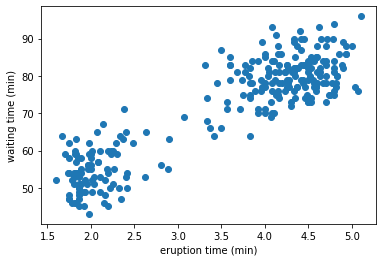

In [2]:
# Load data from a text file
X = np.loadtxt('data/faithful.txt')
N, D = X.shape
plt.scatter(X[:,0], X[:,1])
plt.xlabel('eruption time (min)')
plt.ylabel('waiting time (min)');

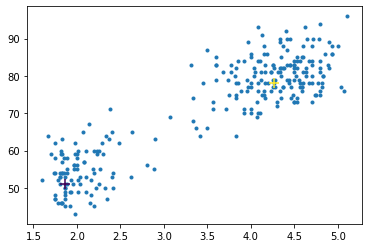

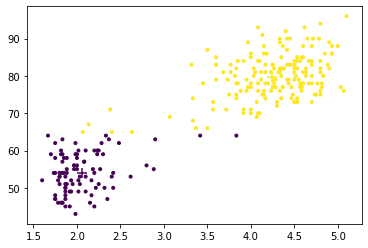

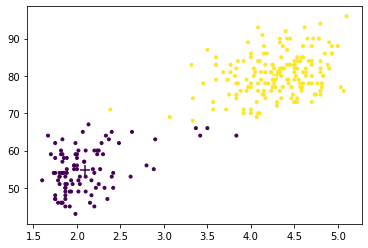

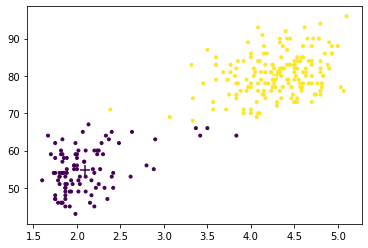

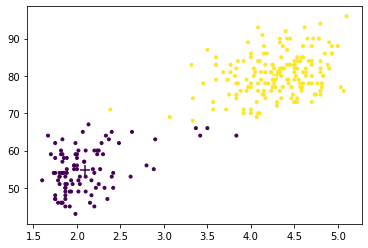

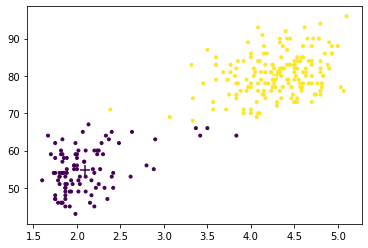

In [3]:
K = 2  # number of clusters
# Initial guess of prototypes
Mu = X[np.random.randint(0, N, K),:]   # pick K points randomly
plt.scatter(X[:,0], X[:,1], marker='.')
plt.scatter(Mu[:,0], Mu[:,1], c=range(K), marker='+', s=100)
plt.show()
Y = np.zeros(N, dtype=int)    # cluster label
R = np.zeros((N,K), dtype=bool)   # assignment matrix
for t in range(5):
    # Update assignment
    for n in range(N):
        # check the distances
        dist = [ np.dot(X[n]-Mu[k], X[n]-Mu[k]) for k in range(K)]
        # find the nearest mean
        Y[n] = np.argmin(dist)
        R[n,:] = np.zeros(K)
        R[n,Y[n]] = 1
    # show assignment
    plt.scatter(X[:,0], X[:,1], c=Y, marker='.')
    # Update the means
    for k in range(K):
        Mu[k] = np.mean(X[R[:,k]], axis=0)
    # plot the new means

    plt.scatter(Mu[:,0], Mu[:,1], c=range(K), marker='+', s=100)
    plt.show()

## Mixtures of Gaussians

It is often the case that clusters have some overlaps and assignment is probabilistic. *Mixtures of Gaussians* is a probabilistic extention of $K$-means clustering.

*Gaussian mixture distribution* has a form
$$ p(\b{x}) = \sum_{k=1}^K \pi_{k} \mathcal{N}(\b{x}|\b{\mu}_k, \Sigma_k) $$
where $\b{\mu}_k$ and $\Sigma_k$ are the mean and the variance of $k$-th Gaussian and $\pi_k$ is the mixture probability.

In [4]:
# sample from a Gaussian mixture distribution
def gaussmix(pi, mu, sigma):
    K = len(pi)
    z = np.random.multinomial(1, pi)  # binary stochastic variable
    k = list(z).index(1)    # the index of z_k=1
    x = np.random.multivariate_normal(mu[k], sigma[k])
    return x, k

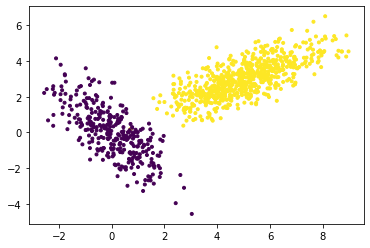

In [5]:
pi = [0.3, 0.7]    # mixture probability
mu = [[0,0], [5,3]]     # means
sigma = [[[1,-1],[-1,2]], [[2,1],[1,1]]]   # variances
N = 1000
X = np.zeros((N,2))
Y = np.zeros(N, dtype=int)
for n in range(N):
    X[n,:], Y[n] = gaussmix(pi, mu, sigma)
plt.scatter(X[:,0], X[:,1], c=Y, marker='.');

## Expectation-maximization (EM) Algorithm

We consider a binary stochastic variable 
$$ \b{z}=(z_1,…,z_K) \mbox{ where } z_k\in\{0,1\} \mbox{ and } \sum_{k=1}^K z_k=1 $$
indicating which Gaussian a data point belongs to.

For fitting the parameters $\pi_k$, $\mu_k$ and $\Sigma_k$ $(k=1,...,K)$, we repeat the following steps, called the *expectation-maximization (EM)* algorithm:

### E (expectation) step

For the current parameters $(\pi_k,\mu_k$,$\Sigma_k)$, evaluate the posterior distribution of $\b{z}$ given $\b{x}$, called *responsibility*:
$$ r_{nk} = p(z_k=1|\b{x}_n) = \frac{\pi_k\c{N}(\b{x}_n|\b{\mu}_k,\Sigma_k)}{\sum_{j=1}^K \pi_j\c{N}(\b{x}_n|\b{\mu}_j,\Sigma_j)} $$

### M (maximization) step

For the current responsibility, estimate new parameters:
$$ N_k = \sum_{n=1}^N r_{nk} $$
$$ \pi_k = \frac{N_k}{N} $$
$$ \b{\mu}_k = \frac{1}{N_k}\sum_{n=1}^N r_{nk}\b{x}_n $$
$$ \Sigma_k = \frac{1}{N_k}\sum_{n=1}^N r_{nk}(\b{x}_n-\b{\mu}_k)(\b{x}_n-\b{\mu}_k)^T $$

In [6]:
X = np.loadtxt('data/faithful.txt')
N, D = X.shape

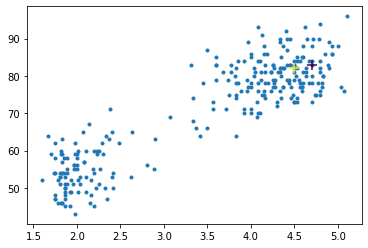

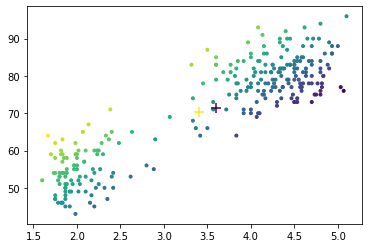

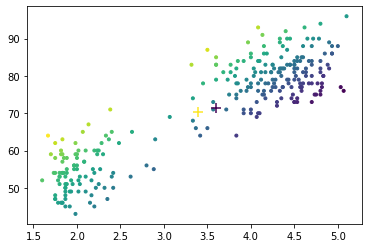

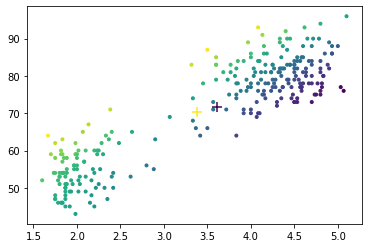

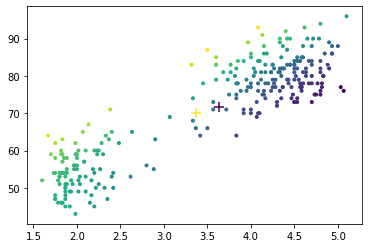

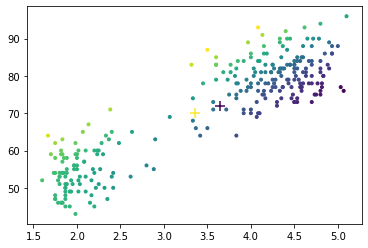

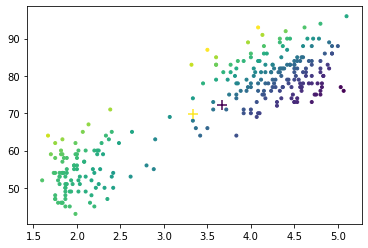

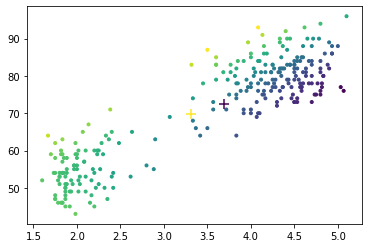

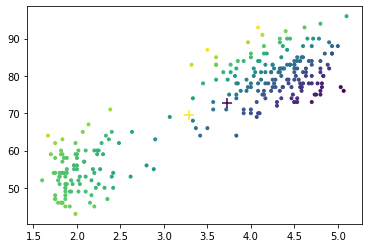

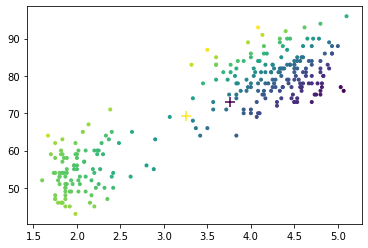

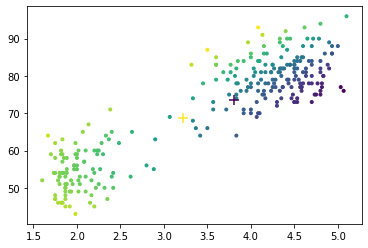

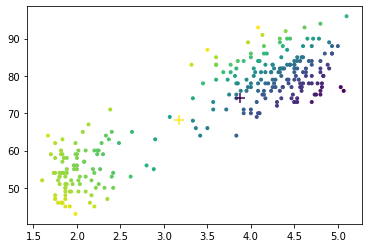

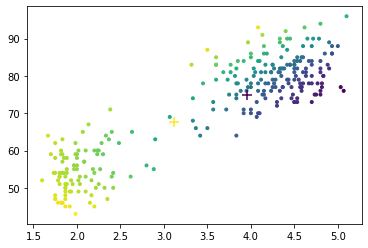

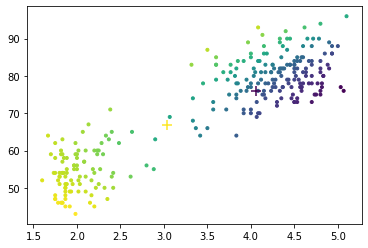

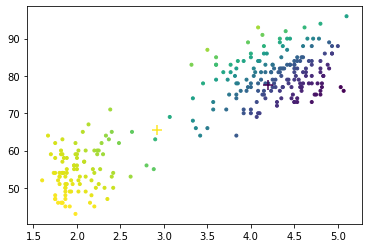

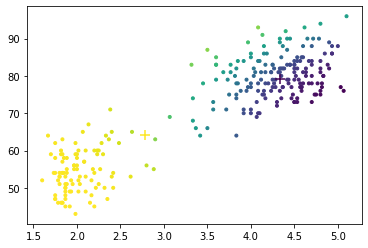

In [7]:
# Initial means, covariance, responsibility
K = 2  # number of clusters
Pi = np.ones(K)/K   # cluster probability
Mu = X[np.random.randint(0, N, K),:]   # pick K points randomly
Sig = np.repeat(np.cov(X.T).reshape(1,D,D), K, axis=0)   # covariance for entire data
plt.scatter(X[:,0], X[:,1], marker='.')
#plt.hold(True)
plt.scatter(Mu[:,0], Mu[:,1], c=range(K), marker='+', s=100)
plt.show()
R = np.zeros((N,K))   # responsibility matrix
pr = np.zeros(K)   # data probability for each cluster
Lambda = np.zeros((K,D,D))  # inverse covariance
detSig = np.zeros(K)    # sqrt(det(Sig))
for t in range(15):
    # Expectation step
    for k in range(K):
        Lambda[k] = np.linalg.inv(Sig[k])   # inverse covariance
        detSig[k] = np.sqrt(np.linalg.det(Sig[k]))
    for n in range(N):
        # check the distances
        for k in range(K):
            #dx = np.matrix(X[n,:] - Mu[k,:])   # deviation from mean
            dx = X[n,:] - Mu[k,:]   # deviation from mean
            pr[k] = Pi[k]*np.exp(-dx@Lambda[k]@dx.T/2)/detSig[k]
        # responsibility
        R[n,:] = pr/np.sum(pr)    # responsibility p(z)
    # show assignment
    plt.scatter(X[:,0], X[:,1], c=np.dot(R,np.arange(K)), marker='.')
    # Maximization step
    num = np.sum(R, axis=0);    # effective numbers for each class
    Pi = num/N    # class prior
    for k in range(K):
        Mu[k,:] = np.sum(R[:,k]*X.T, axis=1)/num[k]
        dX = X - Mu[k,:]
        Sig[k] = R[:,k]/num[k]*dX.T@dX  # cluster covariance    
    # plot the new means
    #plt.hold(True)
    plt.scatter(Mu[:,0], Mu[:,1], c=range(K), marker='+', s=100)
    plt.show()

## Dirichlet Process Mixture
One problem in $K$-means and Mixture of Gaussians is that you have to assume the number of clusters $K$ beforehand.

There is an extension called *Dirichlet process mixture* that decides the number of clusters based on the data.

See Kevin Murphy (2012) Ch. 25.2 for details.

### scikit-learn
[scikit-learn](http://scikit-learn.org/stable/) is a popular Pyhon libraries of supervised and unsupervised learning algorithms with excellent documentation, examples and 
[tutorials](http://scikit-learn.org/stable/tutorial/machine_learning_map)

In [8]:
from sklearn import mixture

In [9]:
mixture.BayesianGaussianMixture?

pi = [6.43593234e-01 3.55683719e-01 6.05387926e-04 1.00850404e-04
 1.68083474e-05]


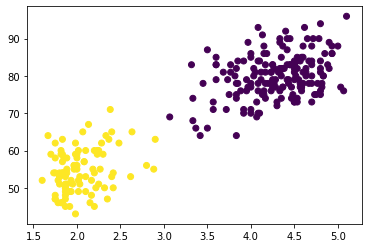

In [10]:
# Create a Dirichlet process mixture of Gaussians
dpm = mixture.BayesianGaussianMixture(n_components=5, max_iter=100)
# Fit to data
dpm.fit(X)
Mu = dpm.means_
Pi = dpm.weights_
#K = dpm.n_components
print("pi =", dpm.weights_)
# class label
Y = dpm.predict(X)
plt.scatter(X[:,0], X[:,1], c=Y)
#plt.scatter(Mu[:,0], Mu[:,1], c=range(K), marker='+',s=300);

## Principal Component Analysis
Grasping the distribution of a high-dimensional data is not easy for human eyes. We often try to find a low-dimensional projection of the data that characteirizes the distribution.

*Principal componet analysis (PCA)* finds the directions of the data distribution with the largest variance. 

Consider a projection of $D$-dimensional vector $\b{x} = (x_1,...,x_D)^T$ to 
$M$-dimensional vector $\b{y} = (y_1,...,y_M)^T$ by 
$$ \b{y} = V \b{x} $$
where $V = (\b{v}_1,...,\b{v}_M)^T$, $||\b{v}_m||=1$.

For a data set $X=(x_1,...,x_N)^T$ with zero mean (mean subtracted),
we try to find the projection by $V$ that make the variance of $\b{y}$ the largest.

Using the data covariance 
$$ C = \frac{1}{N}X^T X = \frac{1}{N}\sum_{n=1}^N \b{x}_n\b{x}_n^T $$
the covariance of projection $\b{z}$ is given as $V^T C V$.

After solving the eigenvalue problem $C\b{v}=\lambda \b{v}$, 
the covariance of projected data is maximized by $V=(\b{v}_1,...,\b{v}_M)^T$ made of the eigenvectors with the largest eigenvalues $\lambda_1,...,\lambda_M$.

In [11]:
# sklearn.datasets offers a wide range of public datasets
from sklearn import datasets
# the iris dataset
iris = datasets.load_iris()
X = iris.data  # flower features
T = iris.target  # flower types
N, D = X.shape
print(N, D)

150 4


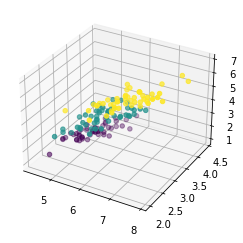

In [12]:
# plot the data in 3D
from mpl_toolkits.mplot3d import Axes3D # for 3D plotting
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=T);

In [13]:
# Data covariance
X = X - np.mean(X, axis=0)  # subtract the mean
C = X.T@X/N
# eigenvalue L[i] and normal eigenvector V[:,i]
L, Vt = np.linalg.eigh( C)   # for symmetric matrix
#L, V = linalg.eig( C)
# in matrix form: C*V=V*L, i.e. C=V*L*V' from V'*V=I
print(L)   # eigenvalues
print(Vt)   # columns are eigenvectors

[0.02367619 0.0776881  0.24105294 4.20005343]
[[ 0.31548719  0.58202985  0.65658877 -0.36138659]
 [-0.3197231  -0.59791083  0.73016143  0.08452251]
 [-0.47983899 -0.07623608 -0.17337266 -0.85667061]
 [ 0.75365743 -0.54583143 -0.07548102 -0.3582892 ]]


[[-0.36138659  0.08452251 -0.85667061 -0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]
 [ 0.58202985 -0.59791083 -0.07623608 -0.54583143]
 [ 0.31548719 -0.3197231  -0.47983899  0.75365743]]


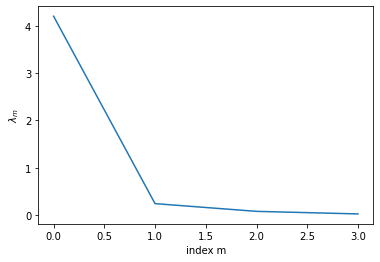

In [14]:
ind = np.argsort(-L)  # largest first
L = L[ind]  # reorder
V = Vt.T[ind]  
print(V)
plt.plot(L)
plt.xlabel("index m")
plt.ylabel("$\lambda_m$");

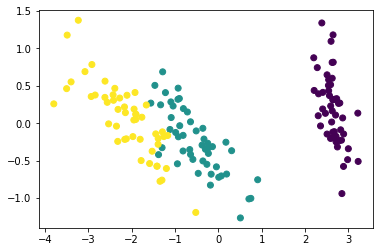

In [15]:
# Projection of data to the PC space
Z = X@V.T
# First two PC
plt.scatter(Z[:,0], Z[:,1], c=T);

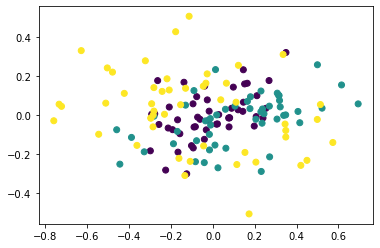

In [16]:
# Last two PC
plt.scatter(Z[:,2], Z[:,3], c=T);

## Singular value decomposition (SVD)

Singular value decomposition (SVD) represents a $N\times D$ matrix ($N>D$) by a weighted sum of products of column vectors $\b{u}_i \in \Re^N$ and row vectors $\b{v}_i^T \in \Re^D$
$$ X = \sum_{i=1}^D s_i \b{u}_i \b{v}_i^T $$
where $\b{v}_i$ are the eigenvectors of $X^T X$ and $s_i= \sqrt{\lambda_i}$ are given by their corresponding eigenvalues ($\lambda_1 \ge ... \ge\lambda_D$).

In a matrix form, SVD is represented as 
$$ X = U S V^T $$
where 
$$ U = (\b{u}_1,...,\b{u}_D) \in \Re^{N\times D} \mbox{(or $\Re^{N\times N}$ with empty columns)} $$
$$ S = \mbox{diag}(\sqrt{\lambda_1},...,\sqrt{\lambda_D}) \in \Re^{D\times D}  \mbox{(or $\Re^{N\times D}$ with empty rows)} $$
$$ V = (\b{v}_1,...,\b{v}_D) \in \Re^{D\times D}. $$

Because $V$ is the same as that for PCA, the SVD is often used for computing 

In [17]:
# X = U*S*V' where S is a diagonal matrix
# i.e. C = X'*X/N = V*S^2/N*V'
U, S, Vs = np.linalg.svd(X)
# See if they match those derived from covariance matrix
print(S**2/N)
print(L)
print(Vs)
print(V)  

[4.20005343 0.24105294 0.0776881  0.02367619]
[4.20005343 0.24105294 0.0776881  0.02367619]
[[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [-0.65658877 -0.73016143  0.17337266  0.07548102]
 [ 0.58202985 -0.59791083 -0.07623608 -0.54583143]
 [ 0.31548719 -0.3197231  -0.47983899  0.75365743]]
[[-0.36138659  0.08452251 -0.85667061 -0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]
 [ 0.58202985 -0.59791083 -0.07623608 -0.54583143]
 [ 0.31548719 -0.3197231  -0.47983899  0.75365743]]


## Online PCA

It has been shown that a simple linear neural network can perform computation similar to PCA (Sanger 1989). 

Let us consider a two-layer network 
$$ \b{y} = W \b{x} $$
with input $\b{x}=(x_1,...,x_D)^T$, output $\b{y}=(y_1,...,y_M)^T$, and $M\times D$ connection weights $W$ ($M<D$).

Consider a *generalized Hebbian algorithm*
In a componet form, it is
$$ \Delta w_{ij} = \alpha(y_i x_j - y_i\sum_{k\le i} w_{kj}y_k) $$
$$ = \alpha[y_i(x_j - \sum_{k<i} w_{kj}y_k) - y_i^2 w_{ij}] $$

In a matrix form, it is represented as
$$ \Delta W = \alpha(\b{y}\b{x}^T - LT[\b{y}\b{y}^T]W) $$
where $LT[\ ]$ takes the lower triangle (including the diagonal) of a matrix.

It has been shown that the rows of matrix $W$ converges to the $M$ eigenvectors with the largest eigen values of the covariance matrix $E[\b{x}\b{x}^T ]$

> ![Sanger89_gha](figures/Sanger89_gha.jpg)
> Figure: The ordered feedback inhibition in generalized Hebbian algorithm (from Sanger 1989).

In [18]:
def gha(X, W, alpha=0.01):
    """Generalized Hebbian Alogrithm by Sanger (1989)"""
    N, D = X.shape
    for n in range(N):
        y = W@X[n,:]
        W += alpha*(np.outer(y, X[n,:]) - np.tril(np.outer(y,y))@W)
    return W

In [19]:
# Iris example
M = 2
W = np.random.randn(M*D).reshape(M,D)
for k in range(10):
    W = gha(X, W, alpha=0.01)
    print(W)

[[ 0.39186765 -0.06118037  0.82479991  0.40732691]
 [ 0.06486767  0.51807397  0.47214257 -0.06983219]]
[[ 0.39270714 -0.01245599  0.83328047  0.39112063]
 [ 0.07855382  0.39270265  0.27413633 -0.04634134]]
[[ 0.39271991 -0.0123657   0.83328722  0.39109553]
 [ 0.1066834   0.37952135  0.1999175  -0.03762977]]
[[ 0.39271996 -0.01236553  0.83328722  0.39109549]
 [ 0.14527027  0.40129416  0.15119435 -0.03386571]]
[[ 0.39271996 -0.01236553  0.83328722  0.39109549]
 [ 0.19458426  0.44266559  0.11010285 -0.03259059]]
[[ 0.39271996 -0.01236553  0.83328722  0.39109549]
 [ 0.25407021  0.49685004  0.07057241 -0.03300923]]
[[ 0.39271996 -0.01236553  0.83328722  0.39109549]
 [ 0.32078859  0.55711581  0.0306773  -0.03467728]]
[[ 0.39271996 -0.01236553  0.83328722  0.39109549]
 [ 0.38898741  0.61532344 -0.0089229  -0.03716148]]
[[ 0.39271996 -0.01236553  0.83328722  0.39109549]
 [ 0.45165273  0.66379433 -0.04596575 -0.03999702]]
[[ 0.39271996 -0.01236553  0.83328722  0.39109549]
 [ 0.50346911  0.69832

In [20]:
W/np.linalg.norm(W, axis=1, keepdims=True)

array([[ 0.39238556, -0.012355  ,  0.83257769,  0.39076248],
       [ 0.58172133,  0.8068612 , -0.09017015, -0.04944336]])

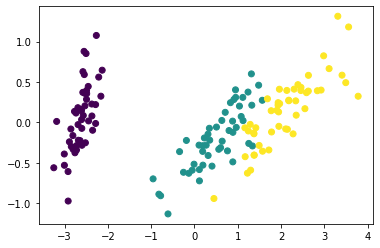

In [21]:
# Projection of data to the PC space
Z = X@W.T
# First two PC
plt.scatter(Z[:,0], Z[:,1], c=T);

## Infomax principle
The *infomax* principle is to find a mapping from input $\b{x}$ to the output $\b{y}$ so that the mutual information
$$ I(\b{y};\b{x}) = H(\b{y}) – H(\b{y}|\b{x}) $$
is maximized.

PCA is an example of infomax by a linear transformation 
$$\b{y}=V\b{x} $$ 
while keeping the norm of the row vectors of matrix $V$ to be one.

For a deterministic mapping or a mapping with homogenetous additive noise $$ \b{y}=f(\b{x})+\b{\epsilon}, $$
$H(\b{y}|\b{x})$ is constant, so that
* maximization of information transfer $I(\b{y};\b{x})$

is equivalent to  
* maximization of output entropy $H(\b{y})$.

Note that $H(\b{y})\le\sum_i H(y_i)$
and the equality is achieved when the output components are independent: $p(\b{y}) = \prod_i p(y_i).$

##  Independent component analysis (ICA)
We can listen to a particular speaker's voice or a sound of an instrument among mixed sound.
This is called *cocktail party effect* or *blind separation*.

For a $D$ independent signal sources $\b{s}=(s_1,...,s_D)^T$, we consider mixture signal 
$$ x_j = \sum_{i=1}^D a_{ji} s_i, $$
or in vector form
$$ \b{x} = A \b{s}. $$

*Independent component analysis (ICA)* tries to recover the original signals by
$$ \b{y} = W\b{x} $$
where components of $\b{y}=(y_1,...,y_D)$ are independent, i.e.,
$$ p(\b{y}) = \prod_{i=1}^D p(y_i), $$

When the amplitude of $y_i$ is bounded, 
the output entropy $H(\b{y})\le\sum_i H(y_i)$ is maximized when $y_i$ are independent.

### ICA by Infomax
If the signal distribution $p(s_i)$ is *supragaussian*, having a sharp peak and long tails, ICA is achieved by a network with saturating output function, such as 
$$ \b{u} = W \b{x} $$
$$ y_i = \tanh(u_i). $$
where $\tanh(u)=\frac{e^u-e^{-u}}{e^u+e^{-u}}$ is a sigmoid function within $(-1,1)$.

In this case, the derivative of the output entropy is given by (Bell & Sejnowski 1995)
$$ \p{H(\b{y})}{W} = {W^T}^{-1} + \b{y}\b{x}^T. $$
The entropy is maximized by the *natural gradient* method (Amari 1998),
$$ \Delta W = \alpha \p{H(\b{y})}{W} W^TW $$
$$ = \alpha({W^T}^{-1} - \b{y}\b{x}^T) W^TW $$
$$ = \alpha(W-\b{y}\b{u}^TW). $$

In [22]:
def ica(X, W=None, alpha=0.01, online=True):
    """ICA by max entropy with tanh()"""
    N, D = X.shape
    if W is None:
        W = np.eye(D)  # initial guess
    if online:
        for n in range(N):
            u = W@X[n,:]  
            y = np.tanh(u)
            W += alpha*(W - np.outer(y,u@W))
    else:  # batch update
        U = X@W.T
        Y = np.tanh(U)
        W += alpha*(W - Y.T@U@W/N)
    return W

[[0.53469186 0.29085788]
 [0.62183216 0.09299044]]


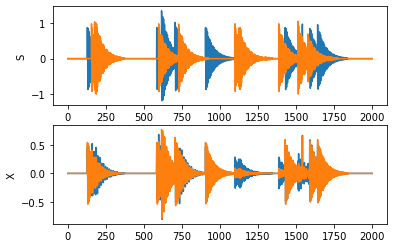

In [23]:
# Make mixed signals of two decaying tones
D = 2  # channels
N = 2000  # signal length
# Source signal
S = np.zeros((N, D))
for i in range(D):
    T = 200  # tone length
    M = 10  # number of tones
    t = np.arange(T)
    s = np.exp(-t/50)*np.sin(0.5*(2+i)*t)  # single tone
    ts = np.random.randint(0, N-T, M)  # start timing
    for m in range(M):
        S[ts[m]:ts[m]+T,i] += s  # add shifted tone
plt.subplot(2, 1, 1)
plt.plot(S)
plt.ylabel("S");
# Mixed signal
A = np.random.random((D,D))   # random matrix
print(A)
X = S@A.T
plt.subplot(2, 1, 2)
plt.plot(X)
plt.ylabel("X");

In [24]:
# Applyy ICA to the mixture
W = np.eye(D)
for k in range(10):
    W = ica(X, W, alpha=0.001)
    print(W@A)
U = X@W.T
Y = np.tanh(U)

[[2.52896881 1.66795875]
 [3.17745578 0.23841199]]
[[ 2.57082473  5.4821323 ]
 [ 6.9122783  -1.41722401]]
[[ 0.76918933  9.19828448]
 [ 9.24610975 -0.76178251]]
[[ 4.42322030e-02  1.00477327e+01]
 [ 9.76104587e+00 -2.08242365e-03]]
[[-0.03678108 10.15336877]
 [ 9.82259918  0.07323498]]
[[-0.04340563 10.16518799]
 [ 9.82917156  0.07934462]]
[[-0.0439291  10.16649508]
 [ 9.82987388  0.07983052]]
[[-0.04397009 10.16663947]
 [ 9.82994958  0.07986898]]
[[-0.04397327 10.16665542]
 [ 9.82995779  0.07987202]]
[[-0.04397351 10.16665718]
 [ 9.82995869  0.07987225]]


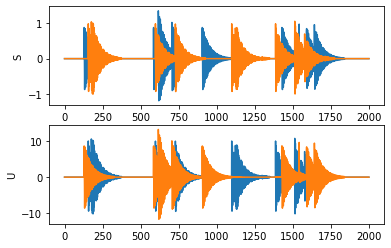

In [25]:
# plot the original and separated signals
plt.subplot(2, 1, 1)
plt.plot(S)
plt.ylabel("S")
plt.subplot(2, 1, 2)
plt.plot(U)
plt.ylabel("U");

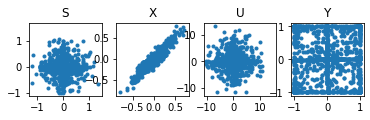

In [26]:
# plot t2D signal distributions
plt.subplot(1, 4, 1)
plt.plot(S[:,0], S[:,1], '.')
plt.axis('square')
plt.title("S")
plt.subplot(1, 4, 2)
plt.plot(X[:,0], X[:,1], '.')
plt.axis('square')
plt.title("X")
plt.subplot(1, 4, 3)
plt.plot(U[:,0], U[:,1], '.')
plt.axis('square')
plt.title("U")
plt.subplot(1, 4, 4)
plt.plot(Y[:,0], Y[:,1], '.')
plt.axis('square')
plt.title("Y");

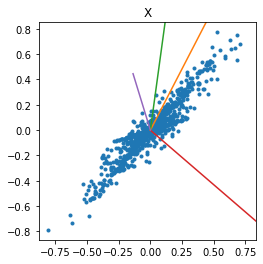

In [27]:
# see how the mixing and separation weights are aligned to mixed data
plt.plot(X[:,0], X[:,1], '.')
plt.axis('square')
plt.title("X")
# estimated mixing vectors
a = np.linalg.inv(W)
a = a/np.max(abs(a))
plt.plot([0, a[0,0]], [0, a[0,1]])
plt.plot([0, a[1,0]], [0, a[1,1]])
# separating vectors
w = W/np.max(W)
plt.plot([0,w[0,0]], [0,w[0,1]])
plt.plot([0,w[1,0]], [0,w[1,1]]);

## Playing sound

Do you want to hear the mixed and separated sounds? 
You can use Python interface to [`portaudio`](http://www.portaudio.com/) library, 
such as [`sounddevice`](https://pypi.org/project/sounddevice/) or [`pyaudio`](https://pypi.org/project/PyAudio/) and package to play sound.

First, install `portaudio` library. On Mac, if you have `brew` tool, you can run:

\$ brew install portaudio

Currently `sounddevice` is not in the anaconda packages, so install by `pip` command:

\$ pip install sounddevice

In [28]:
import sounddevice as sd

In [29]:
# Source sounds
for i in range(D):
    sd.play(S[:,i], samplerate=4000, blocking=True)  # 4kHz sampling, wait till finish

MemoryError: Cannot allocate write+execute memory for ffi.callback(). You might be running on a system that prevents this. For more information, see https://cffi.readthedocs.io/en/latest/using.html#callbacks

In [ ]:
# Mixed sounds
for i in range(D):
    sd.play(X[:,i], samplerate=4000, blocking=True)  # 4kHz sampling, wait till finish

In [ ]:
# Separated sounds
for i in range(D):
    u = U/abs(np.max(U))  # scale in [-1,1]
    sd.play(u[:,i], samplerate=4000, blocking=True)  # 4kHz sampling, wait till finish

## Receptive fields of visual cortex neurons

* Cat visual cortex (Hubel & Wiesel)

* Self-organization (von der Malsburgh)

* by Informax (Linsker)
* by SOM (Obermayer et al.)
* by PCA (Sanger et al.)
* by ICA (Bell & Sejnowski)

### Replicating receptive field tuning

Sanger (1989) trained an *autoencoder* network with patches from natural images as inputs. 
The PCs learned by *generalized Hebbian learning* in the hiddenlayers had input weights similar to the receptive field propertis of visual cortical neurons.

> ![Sanger89_rf](figures/Sanger89_rf.jpg)
> Figure from Sanger (1989)

## References

* Bishop CM (2006) Pattern Recognition and Machine Learning. Springer.  
    * Chapter 9: Mixture models and EM  
    * Chapter 12: Continuous latent variables
    
    
* Murphy K (2012) Machine learning: A probabilistic perspective. MIT press.
    * Chapter 25.2: Dirichlet process mixture models 

### Self Organization

* Hubel DH, Wiesel TN (1959). Receptive fields of single neurones in the cat's striate cortex. Journal of Physiology, 148, 574-91. http://doi.org/10.1113/jphysiol.1959.sp006308
* Hubel DH, Wiesel TN (1962). Receptive fields, binocular interaction and functional architecture in the cat's visual cortex. Journal of Physiology, 160, 106-154. http://doi.org/10.1113/jphysiol.1962.sp006837

* von der Malsburg C (1973). Self-organization of orientation sensitive cells in the striate cortex. Kybernetik, 14, 85-100. 
* Kohonen T (1982). Self-Organized Formation of Topologically Correct Feature Maps. Biol Cybern, 43, 59-69. 

### PCA

* Sanger TD (1989). Optimal unsupervised learning in a single-layer linear feedforward neural network. Neural Networks, 2, 459-473. http://doi.org/10.1016/0893-6080(89)90044-0
* Turk M, Pentland A (1991). Eigenfaces for recognition. Journal of Cognitive Neurosciece, 3, 71-86. http://doi.org/10.1162/jocn.1991.3.1.71

### Infomax and ICA

* Linsker R (1986). From basic network principles to neural architecture. Proceedings of the National Academy of Sciences, USA, 83, 7508-7512, 8390-8394, 8779-8783.  http://doi.org/10.1073/pnas.83.19.7508
* Bell AJ, Sejnowski TJ (1995). An information-maxization approach to blind separation and blind deconvolution. Neural Comput, 7, 1129-1159. http://doi.org/10.1162/neco.1995.7.6.1129 
* Bell AJ, Sejnowski TJ (1997). The “independent components” of natural scenes are edge filters. Vision Research, 37, 3327-3338. http://doi.org/10.1016/s0042-6989(97)00121-1
* Amari S (1998). Natural gradient works efficiently in learning. Neural Comput, 10, 251-276. http://doi.org/10.1162/089976698300017746 


## Exercise

1) Apply $K$-means and Mixtures of Gaussians to a dataset which may have some cluster structure.

2) Apply PCA and SVD to a high-dimensional dataset of your interest and compare the results.

3) Apply ICA to a mixted signal of your interest and whether it can separate the original signals.